# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [127]:
debug = True

In [128]:
import cv2

In [129]:
import random
from datetime import datetime

import numpy as np
import tensorflow as tf
from tensorflow.contrib.layers import flatten

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [130]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = "data/train.p"
testing_file = "data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

print("X_train.shape: {} \ny_train.shape: {}".format(X_train.shape, y_train.shape))
print("X_test.shape: {} \ny_test.shape: {}".format(X_test.shape, y_test.shape))

X_train.shape: (39209, 32, 32, 3) 
y_train.shape: (39209,)
X_test.shape: (12630, 32, 32, 3) 
y_test.shape: (12630,)


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [131]:
### Replace each question mark with the appropriate value.


# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = y_train.ptp() + 1 

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [132]:
import pandas as pd
sign_names=pd.read_csv('signnames.csv', sep=',')

if not debug:
    sign_names

In [133]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

def visualize_class(classId):
    num_images = 8
    examples_train = X_train[np.where(y_train==classId)[0]]
    idx = np.random.choice(len(examples_train), num_images)
    
    f, ax = plt.subplots(1, num_images, figsize=(16,3))
    f.suptitle("{} - {}.".format(classId, sign_names['SignName'][classId]), fontsize='x-large')
    for i in range(num_images):     
        ax[i].imshow(examples_train[idx[i]])
        ax[i].axis('off')
        #ax[i].set_title("# {}".format(idx[i]))

    plt.show()

for c in range(n_classes):
    if not debug:
        visualize_class(c)

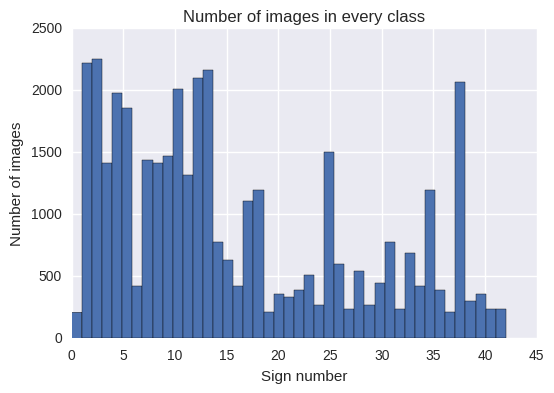

In [134]:
plt.hist(y_train, bins=n_classes)
plt.title("Number of images in every class")
plt.ylabel("Number of images")
plt.xlabel("Sign number")
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

# 1) Data-Preparation

## Show Dark and Bright Images

In [140]:
%matplotlib inline

num_images = 5

random.seed(datetime.now())

def plot_images(offset = 0):
    f, ax = plt.subplots(num_images, num_images)
    for a in range(num_images):
        for i in range(num_images):
            id = offset+i+(a*num_images)
            ax[a][i].imshow(X_train[id])
            ax[a][i].set_title("#{}".format(id))
            ax[a][i].axis('off')
            offset = offset + 1


def plot_random_train(offset = 0):
    f, ax = plt.subplots(num_images, num_images)
    for a in range(num_images):
        for i in range(num_images):
            id = offset
            ax[a][i].imshow(X_train[id])
            ax[a][i].set_title("#{}".format(id))
            ax[a][i].axis('off')
            offset = random.randint(0,len(X_train))

    plt.show()

if not debug:
    plot_random_train()

In [141]:
def plot_dark():
    dark = [571, 3518, 5352, 10535, 14626, 37775, 8372, 8388, 19003, 15310, 30120]

    f, ax = plt.subplots(1, len(dark), figsize=(16,3))

    for i, pic_id in enumerate(dark):
        ax[i].imshow(X_train[pic_id])
        ax[i].axis('off')
        ax[i].set_title("#{}".format(pic_id))

    plt.show()

def plot_bright():
    bright = [424, 1838, 2659, 14788, 421, 2708, 23200, 6249, 21595, 19289]

    f, ax = plt.subplots(1, len(bright), figsize=(16,3))

    for i, pic in enumerate(bright):
        ax[i].imshow(X_train[pic])
        ax[i].axis('off')
        ax[i].set_title("#{}".format(pic_id))
        
    plt.show()


In [142]:
is_features_normal = False
is_labels_encod = False

In [143]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

def rgb2gray(rgb):
    """
    Converts rgb to grayscale and returns 1 channel, using the RGB-> YUV formula, 
    https://www.wikiwand.com/en/YUV#/Conversion_to.2Ffrom_RGB
    """
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
"""
def normalize_grayscale(image_data):
    
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    
    
    a = 0.1
    b = 0.9
    x_max = image_data.max()
    x_min = image_data.min()
    return a + (((image_data-x_min)*(b-a))/(x_max-x_min))
"""
    
def normalize(data):
    #return (data.astype('float32') / 127.5 - 0.5)
    return (data.astype('float32') / 255)

def normalize_YUV(img):
    yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    yuv[:,:,0] = cv2.equalizeHist(yuv[:,:,0])
    return cv2.cvtColor(yuv, cv2.COLOR_YUV2RGB)

# data preperation: Convert to gray and normalize
if not is_features_normal:
    #X_train = normalize(X_train)
    #X_test = normalize(X_test)
    
    #X_train = normalize(X_train)
    #X_test = normalize(X_test)    
    
    
    is_features_normal = True

    

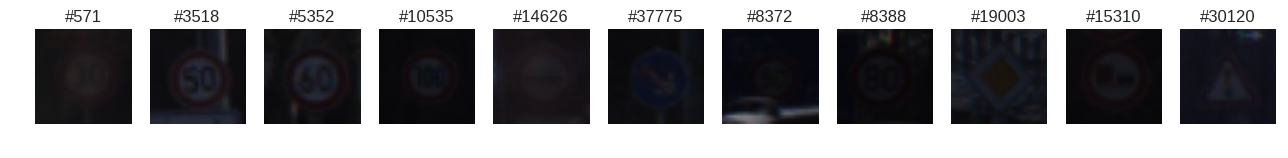

In [144]:
plot_dark()

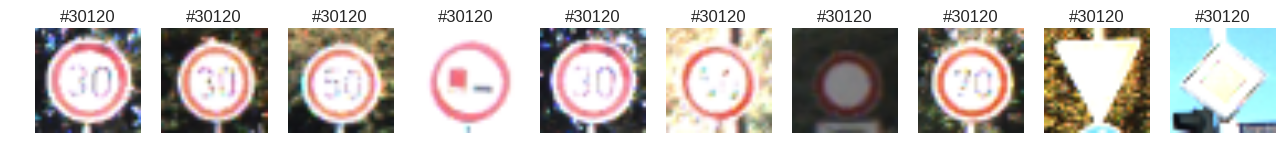

In [145]:
plot_bright()

## Normalize!

In [146]:
## Normalize Training Set
for i, pic in enumerate(X_train):
    X_train[i] = normalize_YUV(X_train[i])

## Normalize Test Set
for i, pic in enumerate(X_test):
    X_test[i] = normalize_YUV(X_test[i])

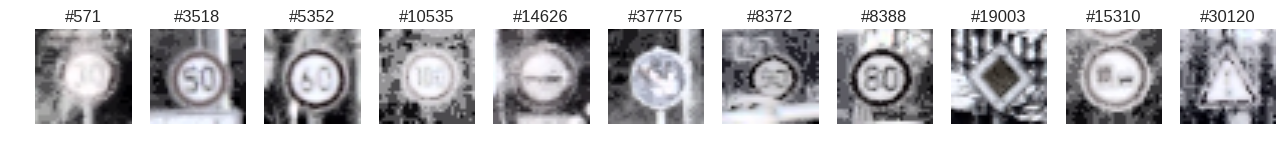

In [147]:
plot_dark()

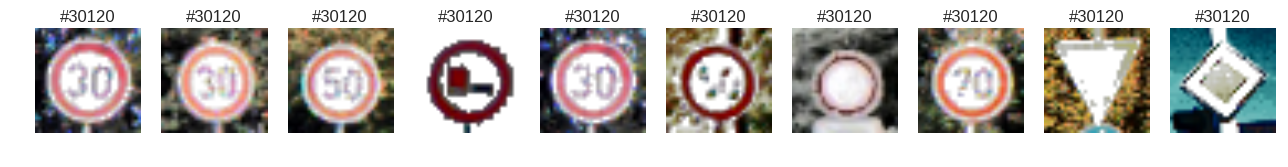

In [148]:
plot_bright()

## One Hot Encoding

In [149]:
# One Hot Encoding

if not is_labels_encod:
    # Turn labels into numbers and apply One-Hot Encoding
    encoder = LabelBinarizer()
    encoder.fit(y_train)
    y_train = encoder.transform(y_train)
    y_test = encoder.transform(y_test)

    # Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
    y_train = y_train.astype(np.float32)
    y_test = y_test.astype(np.float32)
    is_labels_encod = True

In [150]:
#Check if One-Hot Encoding works
print("y_train.shape: {}".format(y_train.shape))
for i in range(5):
    a=random.randint(0,n_train)
    print("index = {}\n{}".format(a, y_train[a]))
    
print("\n\ny_test.shape: {}".format(y_test.shape))
for i in range(5):
    a=random.randint(0,n_test)
    print("index = {}\n{}".format(a, y_test[a]))

y_train.shape: (39209, 43)
index = 16059
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.]
index = 4621
[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.]
index = 2175
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.]
index = 8473
[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.]
index = 17325
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.]


y_test.shape: (12630, 43

## Split in Train, Val and Test

In [151]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, stratify = y_train )

## 2) Covnet

In [152]:
EPOCHS = 10
BATCH_SIZE = 50

In [153]:
def LeNet(x):
    # Reshape from 2D to 4D. This prepares the data for
    # convolutional and pooling layers.
    #x = tf.reshape(x, (-1, 32, 32, 3))

    # 28x28x6
    conv1_W = tf.Variable(tf.truncated_normal([5, 5, 3, 6], stddev = 0.01))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    conv1 = tf.nn.relu(conv1)

    # 14x14x6
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # 10x10x16
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16),stddev = 0.01))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b

    conv2 = tf.nn.relu(conv2)

    # 5x5x16
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')   

    # Flatten
    fc1 = flatten(conv2)
    # (5 * 5 * 16, 120)

    fc1_W = tf.Variable(tf.truncated_normal([400,120],stddev = 0.01))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1 = tf.matmul(fc1, fc1_W) + fc1_b
    fc1 = tf.nn.relu(fc1)

    fc2_W = tf.Variable(tf.truncated_normal(shape=(120, n_classes), stddev = 0.01))
    fc2_b = tf.Variable(tf.zeros(n_classes))
    return tf.matmul(fc1, fc2_W) + fc2_b


In [154]:
# Data consists of 32x32x1, grayscale images
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
# Classify over 43 signs
y = tf.placeholder(tf.float32, (None, n_classes))
fc2 = LeNet(x)

loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(fc2, y))
opt = tf.train.AdamOptimizer(learning_rate=0.001)
train_op = opt.minimize(loss_op)
correct_prediction = tf.equal(tf.argmax(fc2, 1), tf.argmax(y, 1))
accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [155]:
#def next_batch(x_data, y_data, batch_size, step):
#    batch_start = step*batch_size
#    batch_x = x_data[batch_start:batch_start + batch_size]
#    batch_y = y_data[batch_start:batch_start + batch_size]
#    return batch_x, batch_y

def eval_data(X_data, y_data):
    """
    Given a dataset as input returns the loss and accuracy.
    """
    # If dataset.num_examples is not divisible by BATCH_SIZE
    # the remainder will be discarded.
    # Ex: If BATCH_SIZE is 64 and training set has 55000 examples
    # steps_per_epoch = 55000 // 64 = 859
    # num_examples = 859 * 64 = 54976
    #
    # So in that case we go over 54976 examples instead of 55000.
    steps_per_epoch = len(X_data) // BATCH_SIZE
    num_examples = steps_per_epoch * BATCH_SIZE
    total_acc, total_loss = 0, 0
    for step in range(steps_per_epoch):
        batch_start = step * BATCH_SIZE
        batch_end = (step + 1) * BATCH_SIZE
        batch_x = X_data[batch_start:batch_end] 
        batch_y = y_data[batch_start:batch_end]
        #batch_x, batch_y = next_batch(X_data, y_data, BATCH_SIZE, step)
        
        loss, acc = sess.run([loss_op, accuracy_op], feed_dict={x: batch_x, y: batch_y})
        total_acc += (acc * batch_x.shape[0])
        total_loss += (loss * batch_x.shape[0])
    return total_loss/num_examples, total_acc/num_examples


In [156]:
#http://stackoverflow.com/questions/33759623/tensorflow-how-to-restore-a-previously-saved-model-python
#init_op = tf.global_variables_initializer()
#saver = tf.train.Saver()

if __name__ == '__main__':
    
    with tf.Session() as sess:
        #tf.global_variables_initializer()
        sess.run(tf.initialize_all_variables())
        steps_per_epoch = len(X_train) // BATCH_SIZE
        num_examples = steps_per_epoch * BATCH_SIZE

        # Train model
        for i in range(EPOCHS):
            for step in range(steps_per_epoch):
                batch_start = step * BATCH_SIZE
                batch_end = (step + 1) * BATCH_SIZE
                batch_x = X_train[batch_start:batch_end] 
                batch_y = y_train[batch_start:batch_end]
                #batch_x, batch_y = next_batch(X_train, y_train, BATCH_SIZE, step)
                
                loss = sess.run(train_op, feed_dict={x: batch_x, y: batch_y})
            
            val_loss, val_acc = eval_data(X_val, y_val)
            print("EPOCH {} ...".format(i+1))
            print("Validation loss = {:.3f}".format(val_loss))
            print("Validation accuracy = {:.3f}".format(val_acc))
        #saver2.save(sess, 'foo')    
        # Evaluate on the test data
        test_loss, test_acc = eval_data(X_test, y_test)
        print("EPOCH {} ...".format(i+1))
        print("Test loss = {:.3f}".format(test_loss))
        print("Test accuracy = {:.3f}".format(test_acc))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
EPOCH 1 ...
Validation loss = 0.435
Validation accuracy = 0.867
EPOCH 2 ...
Validation loss = 0.242
Validation accuracy = 0.930
EPOCH 3 ...
Validation loss = 0.244
Validation accuracy = 0.929
EPOCH 4 ...
Validation loss = 0.260
Validation accuracy = 0.924
EPOCH 5 ...
Validation loss = 0.172
Validation accuracy = 0.951
EPOCH 6 ...
Validation loss = 0.154
Validation accuracy = 0.961
EPOCH 7 ...
Validation loss = 0.176
Validation accuracy = 0.957
EPOCH 8 ...
Validation loss = 0.235
Validation accuracy = 0.946
EPOCH 9 ...
Validation loss = 0.184
Validation accuracy = 0.958
EPOCH 10 ...
Validation loss = 0.147
Validation accuracy = 0.969
EPOCH 10 ...
Test loss = 0.699
Test accuracy = 0.886


In [157]:
#sess = tf.Session()

predicions = tf.argmax(fc2,1)
predicted_classes = []

with tf.Session() as sess:    
    new_saver = tf.train.import_meta_graph('foo.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))
    
    test_loss, test_acc = eval_data(X_test, y_test)
    print("EPOCH {} ...".format(i+1))
    print("Test loss = {:.3f}".format(test_loss))
    print("Test accuracy = {:.3f}".format(test_acc))
    
    predicted_classes = sess.run(predicions, feed_dict={x: batch_x, y: batch_y})

FailedPreconditionError: Attempting to use uninitialized value Variable_7
	 [[Node: Variable_7/read = Identity[T=DT_FLOAT, _class=["loc:@Variable_7"], _device="/job:localhost/replica:0/task:0/cpu:0"](Variable_7)]]

Caused by op 'Variable_7/read', defined at:
  File "/home/weedjo/anaconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/weedjo/anaconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/weedjo/anaconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/weedjo/anaconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/weedjo/anaconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/weedjo/anaconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/weedjo/anaconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/weedjo/anaconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/weedjo/anaconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/weedjo/anaconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/weedjo/anaconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/weedjo/anaconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/weedjo/anaconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/weedjo/anaconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/weedjo/anaconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/weedjo/anaconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/weedjo/anaconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/weedjo/anaconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/weedjo/anaconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/weedjo/anaconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-154-ad247e82fe61>", line 5, in <module>
    fc2 = LeNet(x)
  File "<ipython-input-153-69d36929c98d>", line 36, in LeNet
    fc2_b = tf.Variable(tf.zeros(n_classes))
  File "/home/weedjo/anaconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 224, in __init__
    expected_shape=expected_shape)
  File "/home/weedjo/anaconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 370, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/home/weedjo/anaconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 1424, in identity
    result = _op_def_lib.apply_op("Identity", input=input, name=name)
  File "/home/weedjo/anaconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 759, in apply_op
    op_def=op_def)
  File "/home/weedjo/anaconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2240, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/weedjo/anaconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1128, in __init__
    self._traceback = _extract_stack()

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value Variable_7
	 [[Node: Variable_7/read = Identity[T=DT_FLOAT, _class=["loc:@Variable_7"], _device="/job:localhost/replica:0/task:0/cpu:0"](Variable_7)]]


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

I divided all pixels by 255, to normalize the values between 0 and 1. For the labels I used one hot encoding. 


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

In [ ]:
I divided the data set into Training, Validation and Testing data. I used 33% of the training data for validation.

In [ ]:
print("Train size: \t\t{}\nValidiation size: \t{}\nTest size: \t\t{}".format(X_train.shape, X_val.shape, X_test.shape))

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

LeNet Architecture

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


Optimizer AdamOptimizer with a learning_rate=0.001
EPOCHS = 10
BATCH_SIZE = 50


### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**First try:** 

EPOCH 10 ...
Test loss = 0.892
Test accuracy = 0.811

<br><br><br>
**Test#1 Changed Normalisation to -1 to +1**

EPOCH 10 ...
Validation loss = 0.121
Validation accuracy = 0.967

EPOCH 10 ...
Test loss = 0.867
Test accuracy = 0.877

**DECISION: Change Normalisation to -1 to +1**

<br><br><br>
**Test#2 Try grayscale**

EPOCH 10 ...
Validation loss = 0.353
Validation accuracy = 0.899
EPOCH 10 ...
Test loss = 1.212
Test accuracy = 0.796

**DECISION: Discard grayscale and stick to color**

<br><br><br>
**Test#3 Try Normalisation with OpenCV-histogram_equalization http://docs.opencv.org/trunk/d5/daf/tutorial_py_histogram_equalization.html**

EPOCH 10 ...
Validation loss = 0.147
Validation accuracy = 0.969
EPOCH 10 ...
Test loss = 0.699
Test accuracy = 0.886

**DECISION: Better results! I will stick to this normalisation**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
7490### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.